# 核心能力提升班商业智能方向 004期 Week 8

### Thinking 1: 今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一

时序数据库是主要存储时序数据的数据库，相较于传统关系数据库有更多针对时序数据的优化。时序数据是一系列按照时间顺序生成或保存的数据，其主要以时间维度为索引。时序数据常常是一些实时监控数据，他们随着时间生成，并且通常是同时生成不同维度乃至不同模态的数据。随着移动互联网、万物互联技术的发展，人们主动（撰写微博、发朋友圈等）和被动（步数、地点信息、购买记录等）产生的信息被采集并传输到服务器上保存下来，这些信息随着时间增长并且高并发，往往也会保留历史信息而不是覆盖，所以会成为增长最快的数据类型之一。

### Thinking 2: BCG Matrix（波士顿矩阵）四象限分别代表什么？不同象限，有怎样的数据决策

波士顿矩阵四个象限分别是明星业务、金牛业务、瘦狗业务和问题业务。  
* 明星业务代表市场增长速度快，市场占有率高。处于高速发展期。需要加大投资，促进增长。  
* 金牛业务代表市场增长速度慢，市场占有率高。处于稳定期。无需增大投资，需要维持现有市场。  
* 问题业务代表市场增长速度快，市场占有率低。处于叫卖不叫座的状态。选择性进行投资。
* 瘦狗业务代表市场增长速度慢，市场占有率低。处于成长性差的状态。采取撤退策略。

### Action 1: 股票价格预测
任何股票价格预测，比如 美吉姆  
http://quotes.money.163.com/trade/lsjysj_002621.html  
历史数据（从1990年12月19日至今）  
请你编写代码对该股票未来3个月的变化进行预测（可以按照月来统计，也可以按照天）  
模型选择：ARMA/ARIMA/LSTM 中的任意一种  

In [1]:
# 用ARMA进行时间序列预测
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from itertools import product
from datetime import datetime, timedelta
import calendar

In [2]:
# 数据加载
df = pd.read_csv('data/000725.csv', encoding='gbk')
df.head()

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2020-10-16,'000725,京东方Ａ,4.92,4.98,4.87,4.96,4.97,-0.05,-1.006,1.3595,460342795,2.260683e+09,1.712081e+11,1.666024e+11
1,2020-10-15,'000725,京东方Ａ,4.97,5.04,4.95,5.00,5.05,-0.08,-1.5842,1.5383,520895350,2.596185e+09,1.729480e+11,1.682956e+11
2,2020-10-14,'000725,京东方Ａ,5.05,5.17,4.99,5.17,5.17,-0.12,-2.3211,2.2293,754901230,3.809337e+09,1.757319e+11,1.710045e+11
3,2020-10-13,'000725,京东方Ａ,5.17,5.21,5.14,5.20,5.25,-0.08,-1.5238,1.6446,556884193,2.876706e+09,1.799077e+11,1.750680e+11
4,2020-10-12,'000725,京东方Ａ,5.25,5.26,5.16,5.22,5.20,0.05,0.9615,2.4131,817117161,4.262624e+09,1.826916e+11,1.777770e+11


In [3]:
df = df[['日期', '收盘价']]
df.columns = ['date', 'price']
df

,date,price
0,2020-10-16,4.92
1,2020-10-15,4.97
2,2020-10-14,5.05
3,2020-10-13,5.17
4,2020-10-12,5.25
...,...,...
4783,2001-01-18,18.92
4784,2001-01-17,18.91
4785,2001-01-16,19.38
4786,2001-01-15,20.49


In [4]:
df.date = pd.to_datetime(df.date)
df.index = df.date

In [5]:
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()

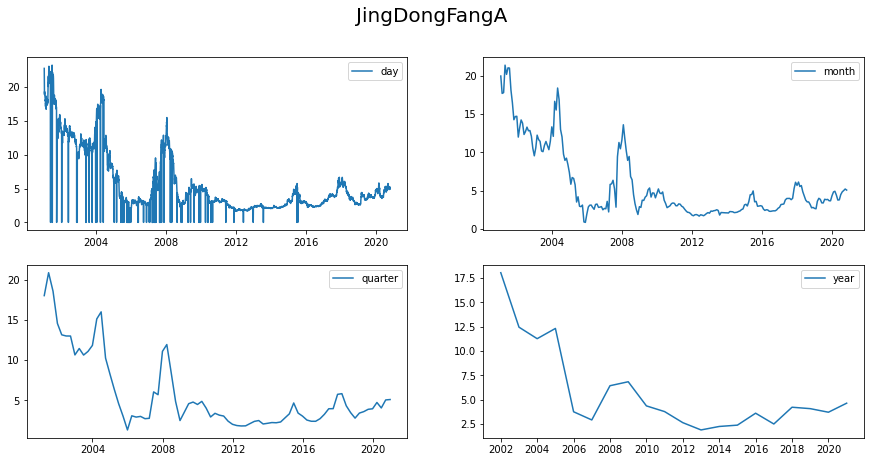

In [6]:
import warnings
warnings.filterwarnings('ignore')
# 按照天，月，季度，年来显示
fig = plt.figure(figsize=[15, 7])
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('JingDongFangA', fontsize=20)
plt.subplot(221)
plt.plot(df.price, '-', label='day')
plt.legend()
plt.subplot(222)
plt.plot(df_month.price, '-', label='month')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.price, '-', label='quarter')
plt.legend()
plt.subplot(224)
plt.plot(df_year.price, '-', label='year')
plt.legend()
plt.show()

#### ARMA

In [7]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                                ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  238
Model:                     ARMA(1, 0)   Log Likelihood                -350.041
Method:                       css-mle   S.D. of innovations              1.045
Date:                Mon, 19 Oct 2020   AIC                            706.082
Time:                        22:57:26   BIC                            716.499
Sample:                    01-31-2001   HQIC                           710.280
                         - 10-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.1785      3.906      2.094      0.036       0.522      15.835
ar.L1.price     0.9853      0.012     83.839      0.000       0.962       1.008
                                    Roots

In [8]:
results[-1]

[(2, 2), 710.9379896992168]

In [9]:
def vis_of_model(df_month, best_model):
    # 设置future_month，需要预测的时间date_list
    df_month2 = df_month[['price']]
    future_month = 3
    last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
    date_list = []
    for i in range(future_month):
        # 计算下个月有多少天
        year = last_month.year
        month = last_month.month
        if month == 12:
            month = 1
            year = year+1
        else:
            month = month + 1
        next_month_days = calendar.monthrange(year, month)[1]
        last_month = last_month + timedelta(days=next_month_days)
        date_list.append(last_month)
    # 添加未来要预测的3个月
    future = pd.DataFrame(index=date_list, columns= df_month.columns)
    df_month2 = pd.concat([df_month2, future])
    df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
    plt.figure(figsize=(30,7))
    df_month2.price.plot(label='label')
    df_month2.forecast.plot(color='r', ls='--', label='predict')
    plt.legend()
    plt.title('JingDongFangA(month)')
    plt.xlabel('year')
    plt.ylabel('price')
    plt.show()
    return df_month2

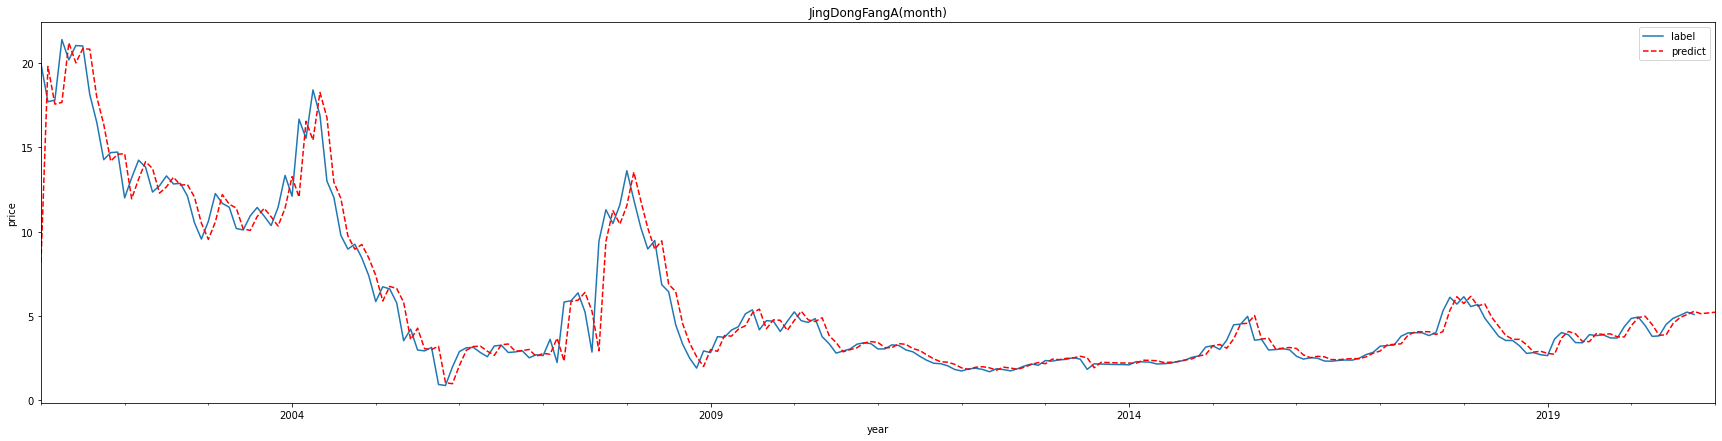

,price,forecast
2001-01-31,19.968333,8.178540
2001-02-28,17.701667,19.795324
2001-03-31,17.805455,17.561919
2001-04-30,21.390000,17.664184
2001-05-31,20.186667,21.196128
...,...,...
2020-09-30,5.235000,5.088403
2020-10-31,5.093333,5.278195
2020-11-30,NaN,5.138607
2020-12-31,NaN,5.183217


In [10]:
vis_of_model(df_month, best_model)

#### ARIMA

In [11]:
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #model = ARIMA(df_month.Price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df_month.price,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                                 SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  238
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -325.233
Date:                Mon, 19 Oct 2020   AIC                            662.467
Time:                        22:57:33   BIC                            683.173
Sample:                    01-31-2001   HQIC                           670.816
                         - 10-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6401      0.024     67.992      0.000       1.593       1.687
ar.L2         -0.9257      0.019    -49.764      0.000      -0.962      -0.889
ma.L1         -1.7309     82.301     -0.021  

In [12]:
results[-1]

[(4, 1, 4), 664.3160380612616]

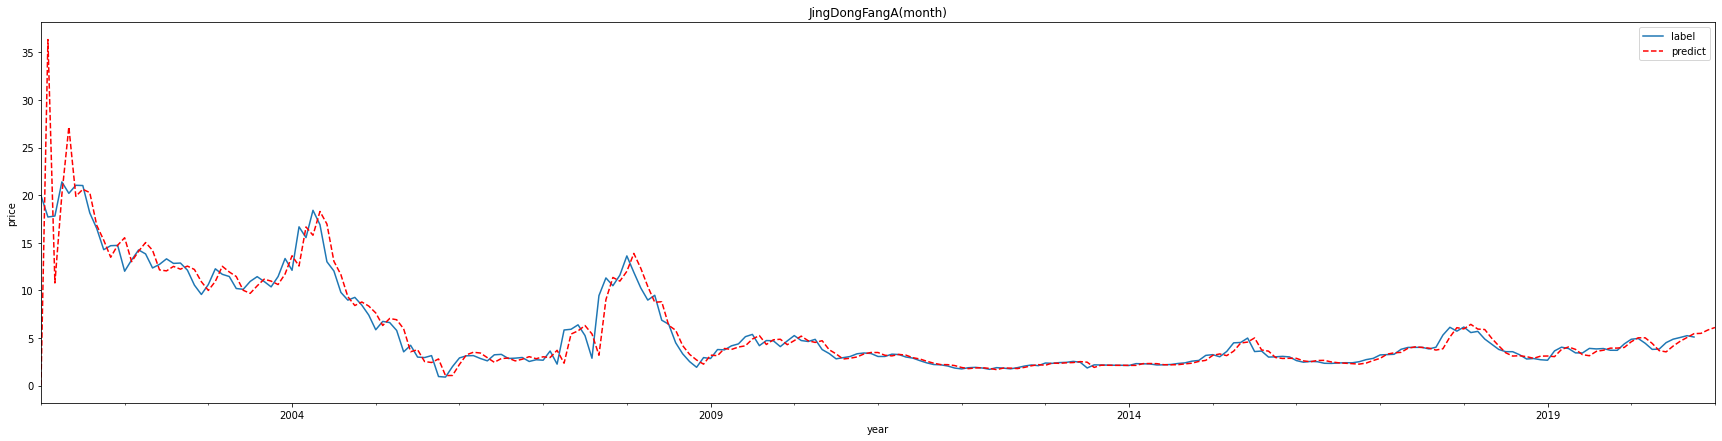

,price,forecast
2001-01-31,19.968333,0.000000
2001-02-28,17.701667,36.343370
2001-03-31,17.805455,10.776476
2001-04-30,21.390000,20.073942
2001-05-31,20.186667,27.172939
...,...,...
2020-09-30,5.235000,5.041134
2020-10-31,5.093333,5.446797
2020-11-30,NaN,5.478837
2020-12-31,NaN,5.837784


In [13]:
vis_of_model(df_month, best_model)

#### LSTM

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from itertools import chain
from sklearn.metrics import mean_squared_error

In [15]:
# 加载数据
data_set = df[['price']].values.astype('float64')

In [16]:
# 设置观测数据input(X)的步长（时间步），epochs，batch_size
timesteps_in = 3
timesteps_out = 3
epochs = 500
batch_size = 100

In [17]:
# 转化为可以用于监督学习的数据
train_data_set = np.array(data_set)

In [18]:
n_vars = 1 if type(train_data_set) is list else train_data_set.shape[1]
data = pd.DataFrame(train_data_set)
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(timesteps_in, 0, -1):
    cols.append(data.shift(i))
    names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
# 预测序列 (t, t+1, ... t+n)
for i in range(0, timesteps_out):
    cols.append(data.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
# 拼接到一起
agg = pd.concat(cols, axis=1)
agg.columns = names
# 去掉NaN行
agg.dropna(inplace=True)

In [19]:
reframed_train_data_set = np.array(agg.values)
reframed_train_data_set

array([[ 4.92,  4.97,  5.05,  5.17,  5.25,  5.2 ],
       [ 4.97,  5.05,  5.17,  5.25,  5.2 ,  4.91],
       [ 5.05,  5.17,  5.25,  5.2 ,  4.91,  5.02],
       ...,
       [18.15, 17.93, 19.34, 18.92, 18.91, 19.38],
       [17.93, 19.34, 18.92, 18.91, 19.38, 20.49],
       [19.34, 18.92, 18.91, 19.38, 20.49, 22.77]])

In [20]:
reframed_train_data_set.shape

(4783, 6)

In [21]:
train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
# 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))

In [22]:
# 使用LSTM进行预测
model = Sequential()
    
# 第一层, 隐藏层神经元节点个数为128, 返回整个序列
model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
# 第二层，隐藏层神经元节点个数为128, 只返回序列最后一个输出
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
# 第三层 因为是回归问题所以使用linear
model.add(Dense(timesteps_out, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
# LSTM训练 input_epochs次数, verbose = 2 为每个epoch输出一行记录, =1为输出进度条记录, =0 不在标准输出流输出日志信息
res = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4783 samples
Epoch 1/500
4783/4783 - 4s - loss: 12.5134
Epoch 2/500
4783/4783 - 1s - loss: 8.0397
Epoch 3/500
4783/4783 - 1s - loss: 6.0573
Epoch 4/500
4783/4783 - 1s - loss: 4.5086
Epoch 5/500
4783/4783 - 1s - loss: 3.4235
Epoch 6/500
4783/4783 - 1s - loss: 3.2437
Epoch 7/500
4783/4783 - 1s - loss: 2.8165
Epoch 8/500
4783/4783 - 1s - loss: 3.5301
Epoch 9/500
4783/4783 - 1s - loss: 3.0696
Epoch 10/500
4783/4783 - 1s - loss: 3.0602
Epoch 11/500
4783/4783 - 1s - loss: 2.5670
Epoch 12/500
4783/4783 - 1s - loss: 3.5247
Epoch 13/500
4783/4783 - 1s - loss: 2.9106
Epoch 14/500
4783/4783 - 1s - loss: 2.5778
Epoch 15/500
4783/4783 - 1s - loss: 2.2874
Epoch 16/500
4783/4783 - 1s - loss: 2.2416
Epoch 17/500
4783/4783 - 1s - loss: 2.2797
Epoch 18/500
4783/4783 - 1s - loss: 2.6181
Epoch 19/500
4783/4783 - 1s - loss: 2.5135
Epoch 20/500
4783/4783 - 1s - loss: 3.1018
Epoch 21/500
4783/4783 - 1s - lo

In [24]:
# 模型预测
train_predict = model.predict(train_x)
#test_data_list = list(chain(*test_data))
train_predict_list = list(chain(*train_predict))

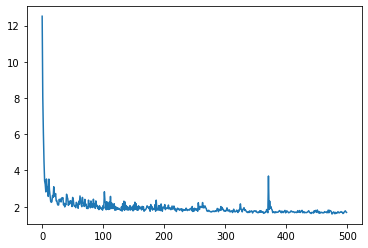

In [25]:
plt.plot(res.history['loss'], label='train')
plt.show()

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 198,531
Trainable params: 198,531
Non-trainable params: 0
_________________________________________________________________


No handles with labels found to put in legend.


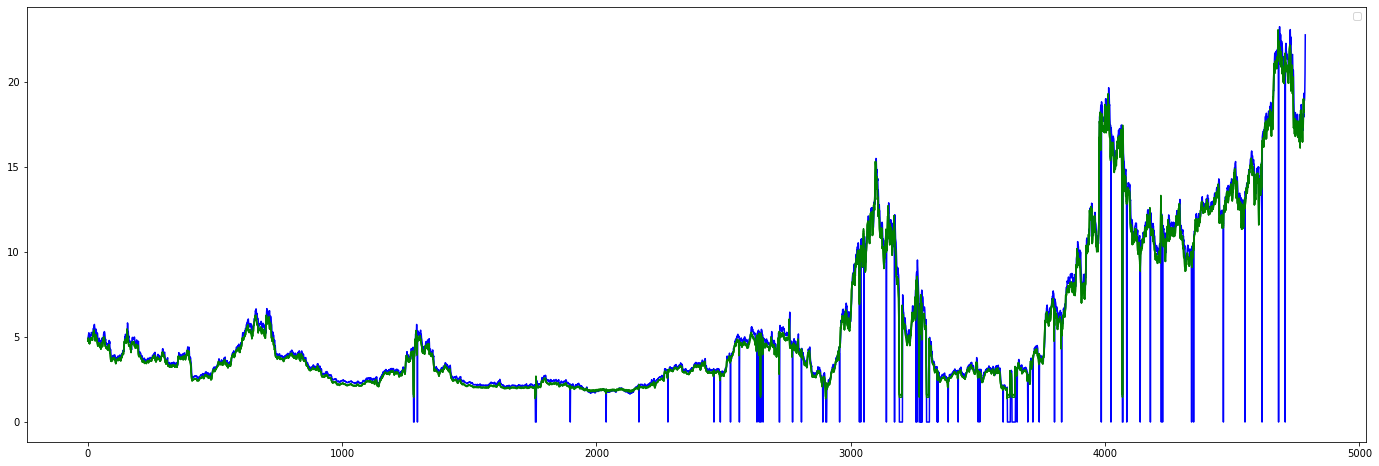

In [28]:
plt.figure(figsize=(24, 8))
# 原始数据蓝色
plt.plot(data_set[:, -1], c='b')
# 训练数据绿色
plt.plot([x for x in train_predict], c='g')
plt.legend()
plt.show()